In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
import random 
from itertools import cycle
from ipywidgets import widgets, interactive
from tqdm.autonotebook import tqdm
import datetime
import seaborn as sns

tqdm.pandas()
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
df_calendar = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
df_calendar = df_calendar.iloc[:1913]
df_sales_train = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')

# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
df_sales_train['item_store_id'] = df_sales_train.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = df_sales_train.loc[:,'d_1':'d_1913'].T #transpose
DF_Sales.columns = df_sales_train['item_store_id'].values
DF_Sales=DF_Sales.reset_index(drop = True) 

DF_Sales['sales'] = DF_Sales.iloc[:,-30490:].sum(axis=1)
toplevel = DF_Sales['sales'] 
DF_Sales = DF_Sales.iloc[:,:30490]

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel




Una prima osservazione sulle seire dell'ultimo livello è la seguente.
Tutte le serie hanno caratteristiche diverse tra loro, ci sono alcune che hanno vendite molto alte e frequenti e altre che hanno pochissime vendite e molto sporadiche. Per esempio prendendonde un campione a caso:

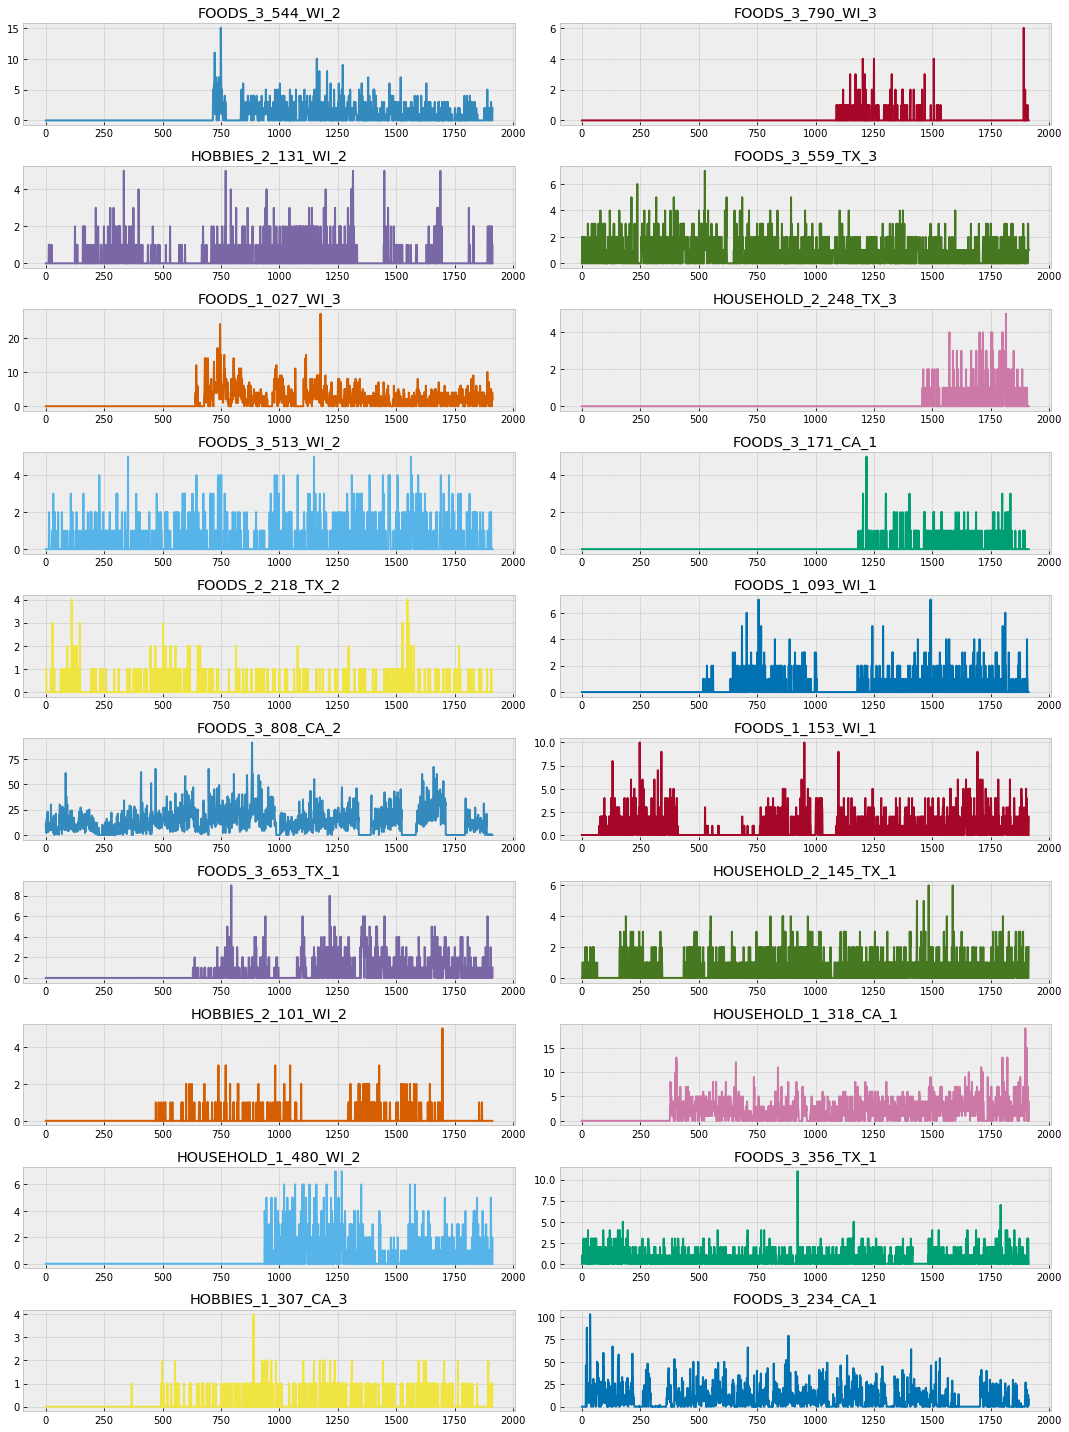

In [10]:
twenty_examples = DF_Sales.sample(20, random_state=123456, axis = 1) 

fig, axs = plt.subplots(10, 2, figsize=(15, 20))
axs = axs.flatten()
ax_idx = 0
for item in twenty_examples.columns:
    twenty_examples[item].plot(title=item,
                              color=next(color_cycle),
                              ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

## Analisi del grado di intermittenza

Analizzando il grado di intermittenza di ognuna delle 30490 serie di basso livello vado quindi a caloclare il nummero di zeri per ogni serie:

In [11]:
zero_els = []
for i in DF_Sales.columns:
    zero_els.append(np.count_nonzero(DF_Sales.loc[:,i].to_numpy()==0))
df = pd.DataFrame([zero_els], columns = DF_Sales.columns)
df

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,1492,1511,1697,617,950,1261,1559,535,1033,996,1784,1315,1523,852,373,393,963,1834,995,1422,1155,1396,896,1573,1360,...,1489,119,602,1750,364,412,834,1427,626,742,1782,517,1678,832,1223,881,649,532,1267,485,1390,1433,1030,1557,1416


Effettivamente il numero di zeri è molto alto per quasi tutte.
In percentuale si ha quindi:

In [12]:
#dividendo per la lunghezza della serie
df = df/1913
df

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
0,0.779927,0.789859,0.887088,0.32253,0.496602,0.659174,0.81495,0.279665,0.53999,0.520648,0.932567,0.687402,0.796132,0.445374,0.194982,0.205436,0.503398,0.958704,0.520125,0.743335,0.603764,0.729744,0.468374,0.822269,0.710925,...,0.778359,0.062206,0.314689,0.914794,0.190277,0.215369,0.435964,0.745949,0.327235,0.387872,0.931521,0.270256,0.877156,0.434919,0.63931,0.460533,0.339258,0.278097,0.662311,0.253528,0.726607,0.749085,0.538421,0.813905,0.740199


Un'altra possibile analisi per capire il grado di intermittenza delle serie è andare a calolcare gli **interevalli tra due occorrenze positive** e calcolare poi la lunghezza media di questi intervalli.
Nello specifico quindi andare a capire se due occorrenze positive si verificano ad una distanza ravvcinata opppure no.

Questo indice, insieme con la precentuale di zeri, può rappresentare bene il grado di intermittenza della serie. La funzione implementata è la seguente:

In [21]:
def get_intervals_mean(s):
    start,end,L = 0,1,[]
    for i in range(len(s)-1):
        if s[start] == 0:
            start +=1
            end   +=1
        if s[start]!=0 and end < (len(s)-1):
            if s[end] == 0:
                end   +=1
            if s[end] > 0:
                gap = end-start
                #print("gap",gap)
                L.append(gap)
                start = end
                end   += 1    
    if len(L)>0:
        return L, sum(L) / len(L) 
    else:
        return 0
    
#example
series1 = [4,0,0,7,0,5,0,7,8,9,1,5,8,0,1,3,1,6,1]
series2 = [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
print("series1:",get_intervals_mean(series1),"series2:",get_intervals_mean(series2))

series1: ([3, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1], 1.4166666666666667) series2: ([17], 17.0)


Da cui si ottengono i risultati nel nostro caso:

In [18]:
means_int = []
for i in DF_Sales.columns:
    means_int.append(get_intervals_mean((DF_Sales.loc[:,i].to_numpy())))
    
df_m = pd.DataFrame([df.values[0], means_int],columns = DF_Sales.columns, index=['percentage',"mean_gap"])
df_m

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,...,FOODS_3_803_WI_3,FOODS_3_804_WI_3,FOODS_3_805_WI_3,FOODS_3_806_WI_3,FOODS_3_807_WI_3,FOODS_3_808_WI_3,FOODS_3_809_WI_3,FOODS_3_810_WI_3,FOODS_3_811_WI_3,FOODS_3_812_WI_3,FOODS_3_813_WI_3,FOODS_3_814_WI_3,FOODS_3_815_WI_3,FOODS_3_816_WI_3,FOODS_3_817_WI_3,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
percentage,0.779927,0.789859,0.887088,0.322530,0.496602,0.659174,0.814950,0.279665,0.539990,0.520648,0.932567,0.687402,0.796132,0.445374,0.194982,0.205436,0.503398,0.958704,0.520125,0.743335,0.603764,0.729744,0.468374,0.822269,0.710925,...,0.778359,0.062206,0.314689,0.914794,0.190277,0.215369,0.435964,0.745949,0.327235,0.387872,0.931521,0.270256,0.877156,0.434919,0.639310,0.460533,0.339258,0.278097,0.662311,0.253528,0.726607,0.749085,0.538421,0.813905,0.740199
mean_gap,2.410501,4.401496,3.766355,1.448995,1.872008,2.274962,3.923295,1.388808,2.169511,2.085153,11.335938,3.195980,3.711340,1.554297,1.242523,1.258893,1.789030,18.115385,1.510917,3.853061,2.450462,3.699612,1.882759,4.123894,3.072595,...,2.330969,1.066406,1.434683,6.604938,1.234496,1.258667,1.527829,2.909091,1.201556,1.633875,5.223077,1.195839,5.106838,1.449074,2.773585,1.401942,1.513856,1.385507,1.730233,1.340112,3.659004,3.979123,2.165533,2.745763,1.546371


Dove nella prima righa è indicata la precentuale di zeri mentre nella seconda riga l'intervallo medio tra due occorenze positive.

## Feature Engineering

Per catturare il carattere intermittente delle serie ho pensato a due possibili feature, prenendo spunto da [questo link](https://krannert.purdue.edu/masters/business-analytics-and-information-management/student-experiences/experiential-learning/2018/an-investigation-of-forecasting-and-evaluating-intermittent-demand-time-series.php?)
* non-zero interval = l'intervallo di tempo tra due (o anche parametrizzabile in N) precedenti valori non-zero. Tale feature identifica quindi la lunghezza del tempo lungo la quale le vendite occorrono senza interruzioni.

* cumulative zeros  = il numero  di zeri consecutivi prima di un valore positivo. Esso mostra quindi la lunghezza del tempo durante il quale non ci sono vendite.


In [15]:
def positive_consecutive(series):
    count = 0
    L = [0]*len(series)
    for i in range(len(series)):
        if series[i] > 0:
            count = count +1
        if series[i] == 0:
            count = 0
        L[i] = count
    return L

def nonzero_interval(series, interval=2):
    count = 0
    L = [0]*len(series)
    for i in range(len(series)):
        if count  >= interval:
            L[i] = count -(interval-1)
        if series[i] > 0:
            count = count +1
        if series[i] == 0:
            count = 0
    return L


def cumulative_zeros(series):
    count = 0
    L = [0]*len(series)
    for i in range(len(series)):
        if series[i] ==0:
            count = count +1
        if series[i] > 0:
            count = 0
        L[i] = count
    return L

series = [0,0,0,3,4,0,0,7,8,9,1,5,8,0,1,3,0,0,0]
print("example series------",series)

print("2nonzero_interval---",nonzero_interval(series))
print("cumulative_zeros----",cumulative_zeros(series))
print("positive_consecutive",positive_consecutive(series))

example series------ [0, 0, 0, 3, 4, 0, 0, 7, 8, 9, 1, 5, 8, 0, 1, 3, 0, 0, 0]
2nonzero_interval--- [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 3, 4, 5, 0, 0, 1, 0, 0]
cumulative_zeros---- [1, 2, 3, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 3]
positive_consecutive [0, 0, 0, 1, 2, 0, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 0, 0, 0]


Infine analizzando il comportoamento settimanale, mensile e annuale delle serie per i singoli item (quidndi le serei di basso livello) viene fuori che, a seconda della cateogria ( HOBBIES,HOUSEHOLD o FOODS) l'andamento è simile per ogni item indipendentemente dalll stato o dallo store. I tre casi principali sono stati quindi plottati:

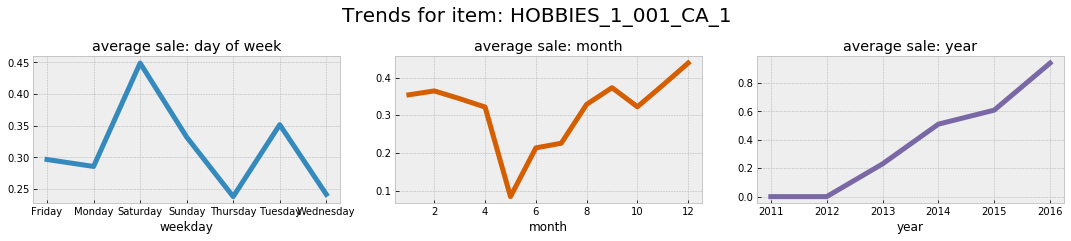

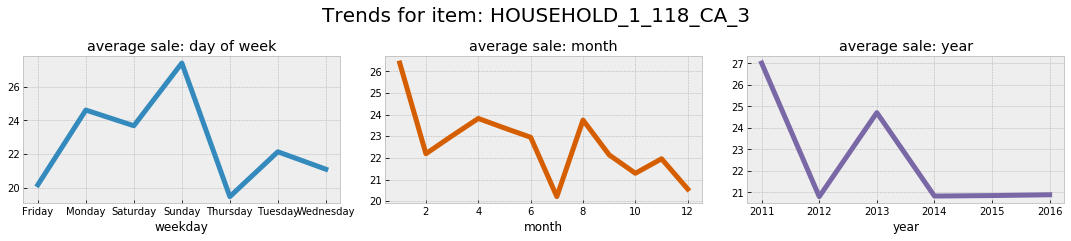

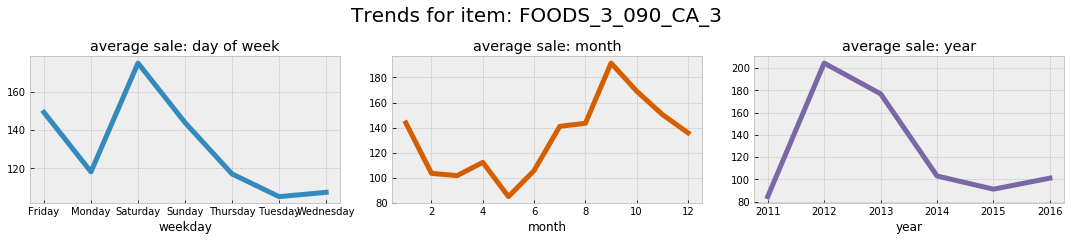

In [16]:
d_cols = [c for c in df_sales_train.columns if 'd_' in c] # sales data columns

# Select more top selling examples 
example1 = df_sales_train.loc[df_sales_train['id'] == 'HOBBIES_1_001_CA_1_validation'][d_cols].T
example1 = example1.rename(columns={0:'HOBBIES_1_001_CA_1'})     # Name it correctly
example1 = example1.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example1 = example1.merge(df_calendar, how='left', validate='1:1')

example2 = df_sales_train.loc[df_sales_train['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example2 = example2.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example2 = example2.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example2 = example2.merge(df_calendar, how='left', validate='1:1')

example3 = df_sales_train.loc[df_sales_train['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example3 = example3.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(df_calendar, how='left', validate='1:1')

examples = ["HOBBIES_1_001_CA_1","HOUSEHOLD_1_118_CA_3", "FOODS_3_090_CA_3"]

example_df = [example1, example2, example3]


for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    
    example_df[i].groupby('weekday').mean()[examples[i]].plot(kind='line', title='average sale: day of week', lw=5, color=color_pal[0],ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]].plot(kind='line',title='average sale: month',       lw=5, color=color_pal[4],ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]].plot(kind='line', title='average sale: year',        lw=5, color=color_pal[2],ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',size=20,y=1.1)
    plt.tight_layout()
    plt.show()